<a href="https://colab.research.google.com/github/LimJH27/LJH/blob/master/translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

# 데이터 준비

In [2]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

In [3]:
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [4]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size: ", len(raw))
print("Example :")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size:  118964
Example :
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


# 데이터 전처리 : 정제

In [5]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    # 소문자 변경
    sentence = sentence.lower().strip()

    # 1. 문장 부호를 \1
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 2. [ ] --> 공백
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 3. 모든 알파벳, 문장기호를 제외한 것들을 공백으로 바꿔주세요.
    sentence = re.sub(r"[^a-zA-Z?!.,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'

    return sentence 

In [6]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English :", enc_corpus[100])
print("Spanish :", dec_corpus[100])

English : go away !
Spanish : <start> salga de aqu ! <end>


# 데이터 전처리 : tokenize

In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [8]:
# 정제된 텍스트를 tokenize()함수를 사용해 토큰화해서 텐서로 변환
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

In [9]:
# 훈련데이터와 검증데이터를 8:2 분리하세요.
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size = 0.2)

In [10]:
# index_word를 활용하여 english vocab size 반환
# index_word를 활용하여 spanish vocab size 반환

print('English Vocab Size :', len(enc_tokenizer.index_word))
print('Spanish Vocab Size :', len(dec_tokenizer.index_word))

English Vocab Size : 4931
Spanish Vocab Size : 8893


# Bahdanau Attention

In [11]:
# 바다나우 어텐션 클래스 만들기
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape : [batch x length x units]
        # h_dec shape : [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))

        attn = tf.nn.softmax(score, axis = 1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)
        
        return context_vec, attn

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        # todo
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        # todo
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        # todo
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state= True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        # todo
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [14]:
BATCH_SIZE = 64
src_vocab_size = len(enc_tokenizer.index_word)+1
tgt_vocab_size = len(dec_tokenizer.index_word)+1

units = 1024
embedding_dim = 512

encoder = Encoder(src_vocab_size, embedding_dim, units)
decoder = Decoder(tgt_vocab_size, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output :', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))
sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_state, sample_output)

print('Decoder output :', sample_logits.shape)
print('Decoder Hidden State :', h_dec.shape)
print('Attention :', attn.shape)

Encoder Output : (64, 30, 1024)
Decoder output : (64, 8894)
Decoder Hidden State : (64, 1024)
Attention : (64, 30, 1)


# 훈련 - Optimizer & loss

In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# Categorical Crossentropy()
# [0.1 0.2 0.7] ----> one hot encoding [0, 0, 1]
# SparseCategoricalCrossentropy
# [0.1 0.2 0.7] ----> 정수 인덱스 2

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype = loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

# 훈련 - Train_step

In [16]:
@tf.function
def train_step(src, tgt, encoder, decoder, opimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<start>']]*bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss/int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [17]:
# 작업 수행 중 프로그램 진행상황 확인 모듈 
!pip install tqdm

In [18]:
from tqdm import tqdm
import random

epochs = 20

for epoch in range(epochs):
    total_loss = 0
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        total_loss += batch_loss

t.set_description_str('Epoch %2d' % (epoch+1))
t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/(batch+1)))

100%|██████████| 375/375 [01:45<00:00,  3.57it/s]


# Evaluate step

In [22]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
  bsz = src.shape[0]
  loss =0

  enc_out = encoder(src)
  h_dec = enc_out[:, -1]

  dec_src = tf.expand_dims([dec_tok.word_index['<start>']]* bsz, 1)

  for t in range(1, tgt.shape[1]):
    pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
    loss += loss_function(tgt[:, t], pred)
    dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss/int(tgt.shape[1]))

  return batch_loss

In [23]:
# Training Process
from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                            dec_train[idx:idx+BATCH_SIZE],
                            encoder,
                            decoder,
                            optimizer,
                            dec_tokenizer)
    total_loss += batch_loss

  t.set_description_str('Epoch %2d' % (epoch +1))
  t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/ (batch+1)))

  test_loss = 0

  idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (test_batch, idx) in enumerate(t):
    test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                dec_val[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                dec_tokenizer)
    test_loss += test_batch_loss

  t.set_description_str('Test Epoch %2d' % (epoch+1))
  t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy()/ (test_batch+1)))

100%|██████████| 94/94 [00:09<00:00,  9.99it/s]


In [24]:
def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
  sentence = preprocess_sentence(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen = enc_train.shape[-1],
                                                         padding= 'post')
  
  result = ''
  enc_out = encoder(inputs)
  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = \
    tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '

    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention


In [25]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [26]:
def translate(sentence, encoder, decoder):
  result, sentence, attention = evaluate(sentence, encoder, decoder)

  print('Input : %s' % (sentence))
  print('Predicted translation : {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
  plot_attention(attention, sentence.split(), result.split(' '))

Input : where is the restroom ?
Predicted translation : d nde est el ba o ? <end> 


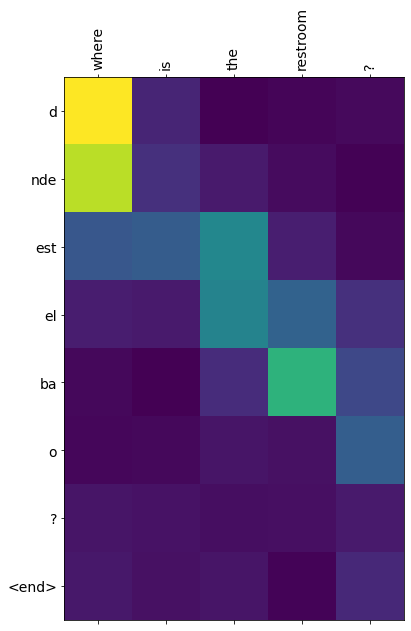

In [27]:
translate("Where is the restroom?", encoder, decoder)